<a href="https://colab.research.google.com/github/Sarthak777999/Tourism-Demand-Forecasting/blob/main/XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_csv("/content/FINAL-DATA-till-2014.csv")
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

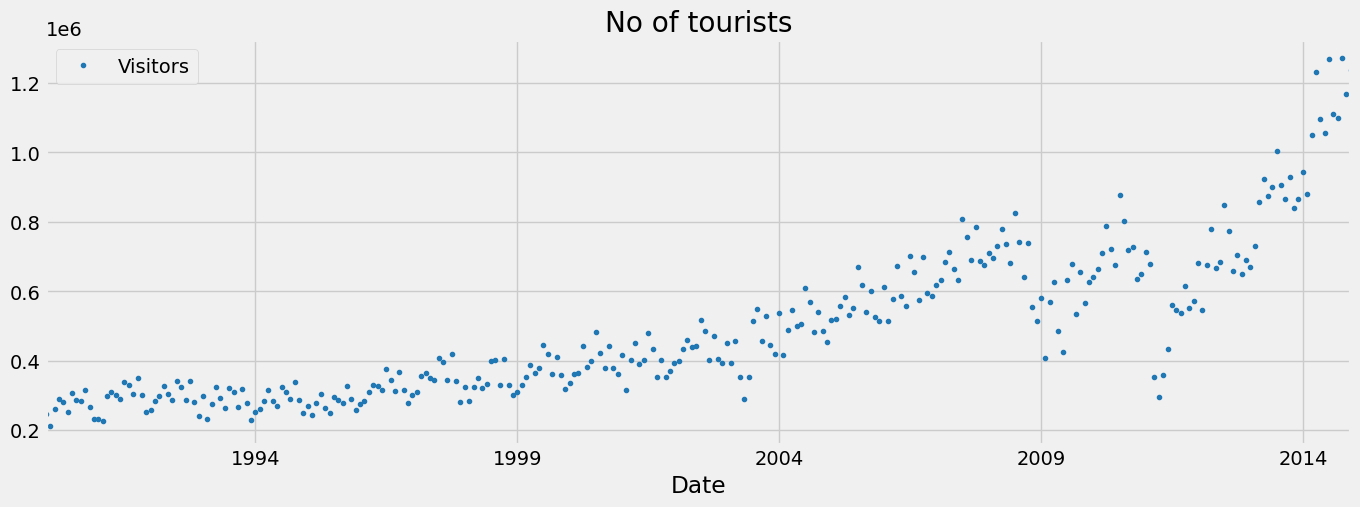

In [ ]:

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='No of tourists')
plt.show()

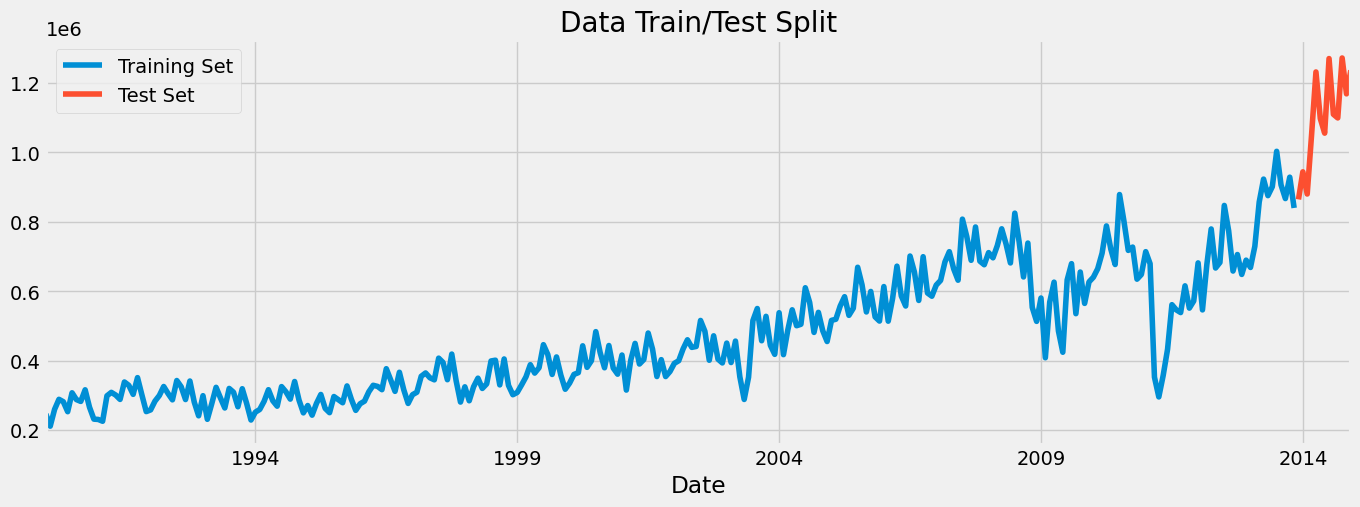

In [ ]:
train = df.loc[df.index < '12-01-2013']
test = df.loc[df.index >= '12-01-2013']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:

train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Visitors'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[15:48:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:493391.84197	validation_1-rmse:1099817.43053
[100]	validation_0-rmse:195792.31791	validation_1-rmse:604526.08726
[200]	validation_0-rmse:92479.97269	validation_1-rmse:403770.98052
[300]	validation_0-rmse:59256.86126	validation_1-rmse:328204.96602
[400]	validation_0-rmse:48799.05817	validation_1-rmse:294270.40643
[500]	validation_0-rmse:44675.50046	validation_1-rmse:277957.92944
[600]	validation_0-rmse:41517.85848	validation_1-rmse:271843.93579
[700]	validation_0-rmse:38780.32365	validation_1-rmse:266210.88127
[800]	validation_0-rmse:36448.73989	validation_1-rmse:261973.79226
[900]	validation_0-rmse:34727.41973	validation_1-rmse:258853.53366
[999]	validation_0-rmse:33356.44212	validation_1-rmse:256679.83142


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

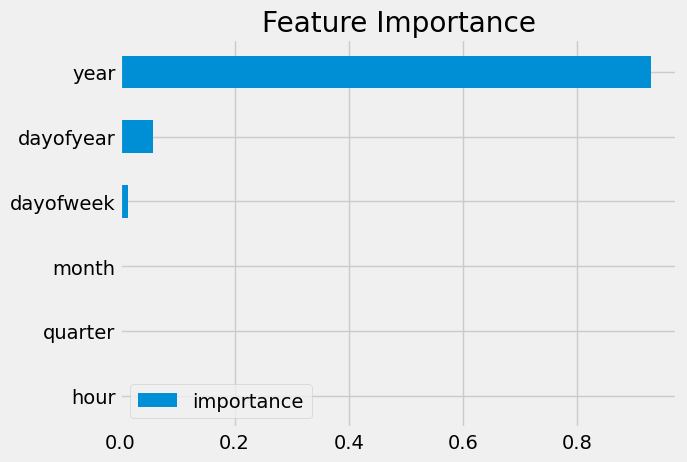

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

plt.show()

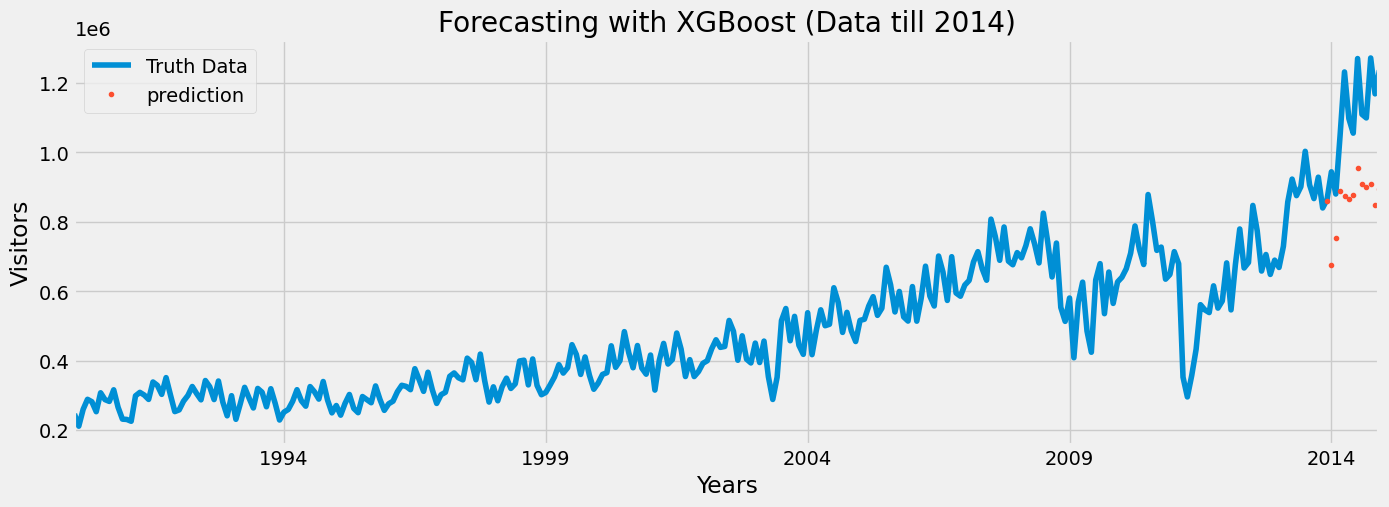

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Visitors']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction'])
ax.set_title('Forecasting with XGBoost (Data till 2014)')
plt.xlabel("Years")
plt.ylabel("Visitors")
plt.show()

In [ ]:

score = np.sqrt(mean_squared_error(test['Visitors'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1248388.86


In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2014-10-01    362211.3125
2014-04-01    355776.6875
2014-12-01    342693.0000
2014-11-01    319355.9375
2014-07-01    315034.8125
2014-01-01    268625.6875
2014-05-01    231186.7500
2014-09-01    200017.8750
2014-08-01    199687.6875
2014-06-01    179053.6875
Name: error, dtype: float64

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
print ('MAE =',mean_absolute_error(test['Visitors'], test['prediction']))

MAE = 236028.44711538462


In [ ]:
print ('MSE =',mean_squared_error(test['Visitors'], test['prediction']))

MSE = 65884536658.132515


In [ ]:
actual = test['Visitors']
pred = test['prediction']

In [ ]:
import numpy as np

def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
print("Mape", mape(actual, pred))

Mape 20.801809658246174


In [ ]:
print("Maape", maape(actual, pred))

NameError: ignored